# Anomaly Detection 

In [3]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True


In [ ]:
import json
from pathlib import Path
import pandas as pd


datasets = ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"]
data_dir = Path("dblp_data") / "dblp-ref"

print("Looking for JSON files in:", data_dir.resolve())

data = []

for dataset in datasets:
    file_path = data_dir / dataset
    print(f"Loading {file_path} ...")

    
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))

df = pd.DataFrame(data)
print("Raw shape:", df.shape)
df.head()


Looking for JSON files in: C:\Users\bpedr\Desktop\COSC_3337\project1.0\dblp_data\dblp-ref
Loading dblp_data\dblp-ref\dblp-ref-0.json ...
Loading dblp_data\dblp-ref\dblp-ref-1.json ...
Loading dblp_data\dblp-ref\dblp-ref-2.json ...
Loading dblp_data\dblp-ref\dblp-ref-3.json ...
Raw shape: (3079007, 8)


,abstract,authors,n_citation,references,title,venue,year,id
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346
1,This paper describes the design and implementa...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,visual analytics science and technology,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,This article applied GARCH model instead AR or...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,NaN,"[Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...",0,"[8c78e4b0-632b-4293-b491-85b1976675e6, 9cdc54f...",Development of Remote Monitoring and Control D...,,2011,00338203-9eb3-40c5-9f31-cbac73a519ec
4,NaN,"[Giovanna Guerrini, Isabella Merlo]",2,NaN,Reasonig about Set-Oriented Methods in Object ...,,1998,0040b022-1472-4f70-a753-74832df65266


In [ ]:
# Basic cleaning + venue filtering (same logic as temp.ipynb)

# Remove entries with missing or empty title or venue
required_cols = ["title", "venue"]
df = df.dropna(subset=required_cols)

for col in ["title", "venue"]:
    df[col] = df[col].astype(str).str.strip()
    df = df[df[col] != ""]

# Remove entries where venue contains "arxiv"
mask_arxiv = df["venue"].str.contains("arxiv", case=False, na=False)
df = df[~mask_arxiv].copy()

# Filter venues with at least min_papers_per_venue papers
min_papers_per_venue = 1000
venue_counts = df["venue"].value_counts()
selected_venues = venue_counts[venue_counts >= min_papers_per_venue].index

venue_df = df[df["venue"].isin(selected_venues)].copy()

print("After cleaning shape:", df.shape)
print("Number of selected venues (>= 1000 papers):", len(selected_venues))
venue_df.head()


After cleaning shape: (2523749, 8)
Number of selected venues (>= 1000 papers): 637


,abstract,authors,n_citation,references,title,venue,year,id
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346
8,NaN,"[Pranay Chaudhuri, Hussein Thompson]",0,NaN,A Self-Stabilizing Algorithm for Finding the C...,parallel and distributed processing techniques...,2003,00745041-3636-4d18-bbec-783c4278c40d
12,"Recently, Bridges and Reich introduced the con...","[Alvaro L. Islas, Constance M. Schober]",50,[],Multisymplectic Spectral Methods for the Gross...,international conference on conceptual structures,2002,00bcf2d5-1592-46b0-81fd-933f90b5ecca
14,Three speech training systems for hearing-impa...,"[Minoru Shigenaga, Yoshihiro Sekiguchi]",0,NaN,Speech training systems using lateral shapes o...,international joint conference on artificial i...,1979,00ca027b-5174-40fa-bf63-9a97c2a5f518
15,NaN,"[Reiko Heckel, Tom Mens, Michel Wermelinger]",50,NaN,Software Evolution through Transformations.,Electronic Notes in Theoretical Computer Science,2003,00dc2bba-3237-4d4e-b541-1205b97df981


In [ ]:
# Aggregate titles per venue + build TF-IDF features

# Combine title into one text field per paper
venue_df["text"] = venue_df["title"] + " "

venue_text = (
    venue_df
    .groupby("venue")["text"]
    .apply(lambda s: " ".join(s))
    .reset_index()
)

tfidf = TfidfVectorizer(
    max_features=1000,      
    stop_words="english"   # remove English stopwords
)

X_venue = tfidf.fit_transform(venue_text["text"])
feature_names = tfidf.get_feature_names_out()

print("TF-IDF matrix shape (venues x features):", X_venue.shape)
print("Example features:", feature_names[:15])

# Drop all-zero rows
row_sums = np.asarray(X_venue.sum(axis=1)).ravel()
non_empty_mask = row_sums > 0

venue_text = venue_text[non_empty_mask].reset_index(drop=True)
X_venue = X_venue[non_empty_mask]

print("After dropping zero rows:", X_venue.shape)
venue_text.head()


TF-IDF matrix shape (venues x features): (637, 1000)
Example features: ['11' '264' '2d' '3d' '802' 'abstract' 'access' 'accuracy' 'accurate'
 'acoustic' 'acquisition' 'action' 'active' 'activity' 'ad']
After dropping zero rows: (637, 1000)


,venue,text
0,A Quarterly Journal of Operations Research,Project Risk Management by a Probabilistic Exp...
1,ACM Computing Surveys,Adaptive Hypermedia and Adaptive Web. Layout ...
2,ACM Sigsoft Software Engineering Notes,The Von Neumann straitjacket: the process cons...
3,ACM Transactions on Mathematical Software,Purpose and Scope: TOMS. Purpose and Scope: C...
4,Acta Informatica,Automatic analysis of inflectional morphems in...


In [ ]:
# Scale features, cluster, and compute anomaly scores

# Convert sparse TF-IDF matrix to dense (venues are relatively few)
X_dense = X_venue.toarray()

# Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

print("Scaled feature matrix shape:", X_scaled.shape)

# Cluster with MiniBatch K-Means 
n_clusters = 8
kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    batch_size=256,
    random_state=42
)
cluster_labels = kmeans.fit_predict(X_scaled)
centers = kmeans.cluster_centers_

# Anomaly score = distance from each venue to its own cluster center
dists = []
for i in range(X_scaled.shape[0]):
    center = centers[cluster_labels[i]]
    d = np.linalg.norm(X_scaled[i] - center)
    dists.append(d)

venue_text["cluster"] = cluster_labels
venue_text["anomaly_score"] = dists

# Simple summary stats
venue_text["anomaly_score"].describe()


Scaled feature matrix shape: (637, 1000)


count    637.000000
mean      27.258424
std        7.017171
min       12.731359
25%       22.024703
50%       26.496237
75%       31.615824
max       51.454585
Name: anomaly_score, dtype: float64

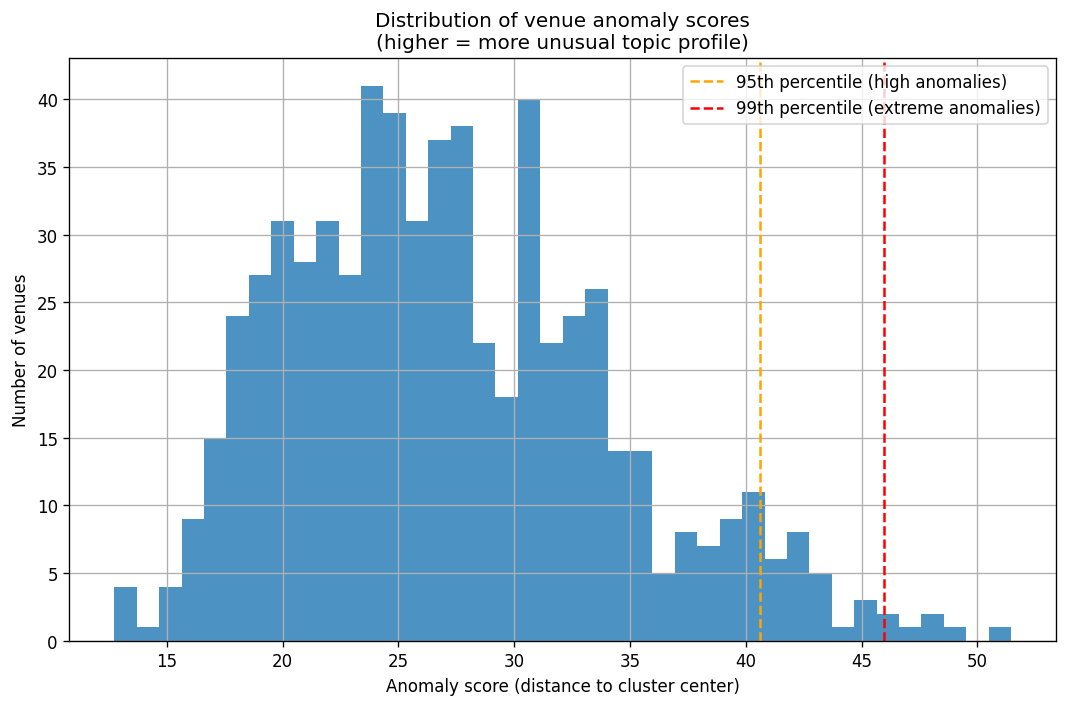

95th percentile anomaly score: 40.60838943957546
99th percentile anomaly score: 45.973189332542965


In [ ]:
# Distribution of venue anomaly scores 

scores = venue_text["anomaly_score"]
q95 = scores.quantile(0.95)
q99 = scores.quantile(0.99)

plt.figure(figsize=(9, 6))
plt.hist(scores, bins=40, alpha=0.8)
plt.axvline(q95, color="orange", linestyle="--", label="95th percentile (high anomalies)")
plt.axvline(q99, color="red", linestyle="--", label="99th percentile (extreme anomalies)")

plt.xlabel("Anomaly score (distance to cluster center)")
plt.ylabel("Number of venues")
plt.title("Distribution of venue anomaly scores\n(higher = more unusual topic profile)")
plt.legend()
plt.tight_layout()
plt.show()

print("95th percentile anomaly score:", q95)
print("99th percentile anomaly score:", q99)


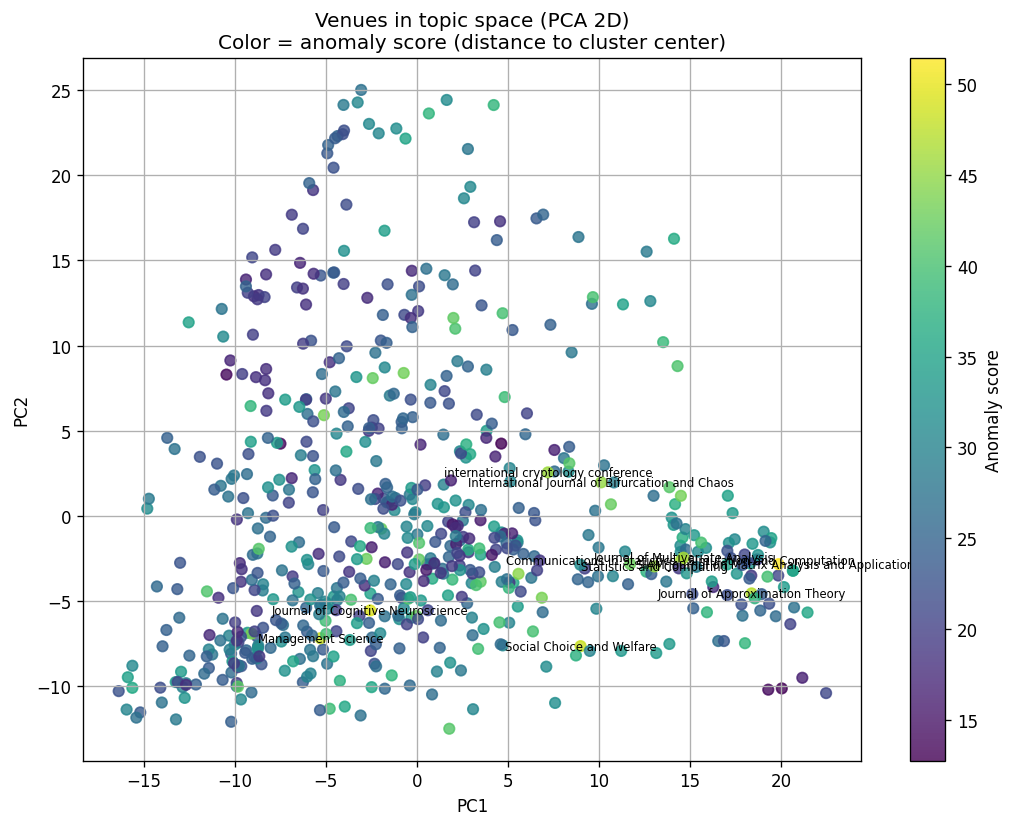

,venue,anomaly_score,cluster
292,SIAM Journal on Matrix Analysis and Applications,51.454585,7
193,Journal of Cognitive Neuroscience,49.415267,6
310,Social Choice and Welfare,48.210850,4
248,Management Science,48.195575,4
188,Journal of Approximation Theory,47.121355,7
34,Communications in Statistics - Simulation and ...,46.324296,6
224,Journal of Multivariate Analysis,46.177867,6
538,international cryptology conference,45.609317,7
313,Statistics and Computing,45.445452,6
173,International Journal of Bifurcation and Chaos,45.250631,4


In [ ]:
# PCA scatter of venues colored by anomaly score 

pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

venue_text["pc1"] = X_pca_2d[:, 0]
venue_text["pc2"] = X_pca_2d[:, 1]

plt.figure(figsize=(9, 7))
scatter = plt.scatter(
    venue_text["pc1"],
    venue_text["pc2"],
    c=venue_text["anomaly_score"],
    s=40,
    alpha=0.8
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Venues in topic space (PCA 2D)\nColor = anomaly score (distance to cluster center)")
cbar = plt.colorbar(scatter)
cbar.set_label("Anomaly score" )

# Label a few of the most anomalous venues to keep plot readable
top_for_labels = venue_text.sort_values("anomaly_score", ascending=False).head(10)

for _, row in top_for_labels.iterrows():
    plt.text(row["pc1"], row["pc2"], row["venue"], fontsize=7,
             ha="center", va="center" )

plt.tight_layout()
plt.show()

top_for_labels[["venue", "anomaly_score", "cluster"]]


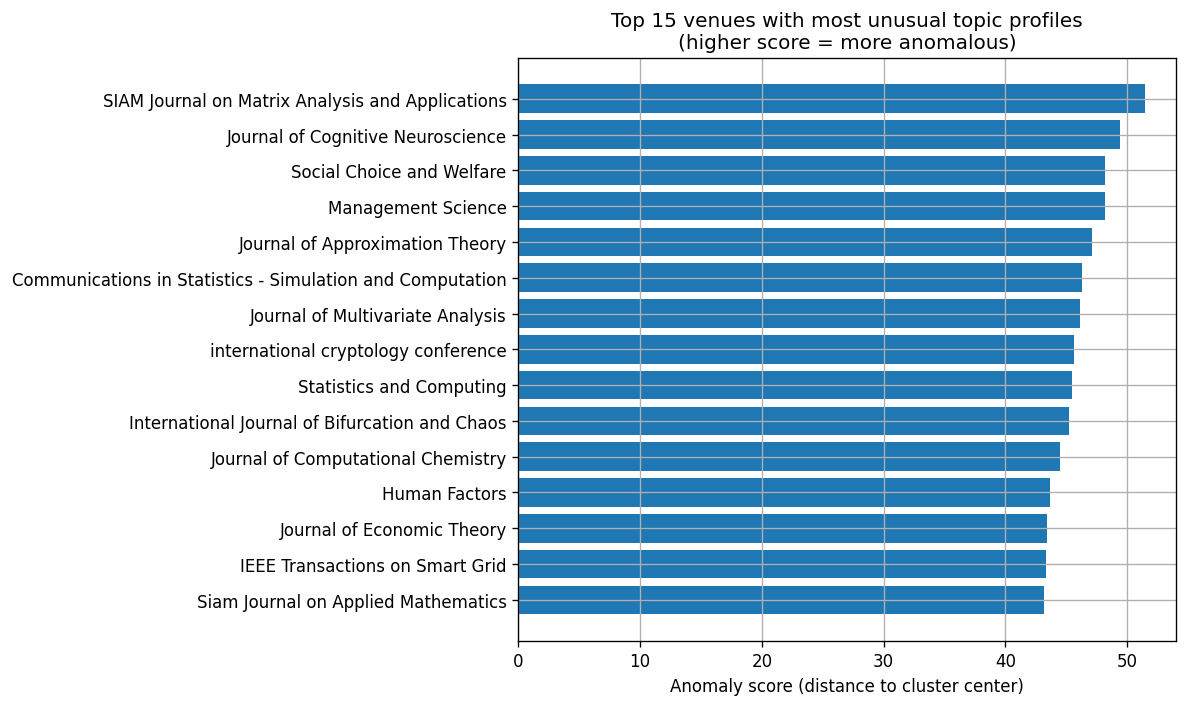

,venue,cluster,anomaly_score
292,SIAM Journal on Matrix Analysis and Applications,7,51.454585
193,Journal of Cognitive Neuroscience,6,49.415267
310,Social Choice and Welfare,4,48.210850
248,Management Science,4,48.195575
188,Journal of Approximation Theory,7,47.121355
34,Communications in Statistics - Simulation and ...,6,46.324296
224,Journal of Multivariate Analysis,6,46.177867
538,international cryptology conference,7,45.609317
313,Statistics and Computing,6,45.445452
173,International Journal of Bifurcation and Chaos,4,45.250631


In [ ]:
# Top 15 most anomalous venues 

top_k = 15
top_anomalous = venue_text.sort_values("anomaly_score", ascending=False).head(top_k)

plt.figure(figsize=(10, 6))
plt.barh(top_anomalous["venue"][::-1], top_anomalous["anomaly_score"][::-1])
plt.xlabel("Anomaly score (distance to cluster center)")
plt.title(f"Top {top_k} venues with most unusual topic profiles\n(higher score = more anomalous)")
plt.tight_layout()
plt.show()

top_anomalous[["venue", "cluster", "anomaly_score"]]


SIAM Journal

In [ ]:
import numpy as np
import pandas as pd


target_venue = "SIAM Journal on Matrix Analysis and Applications"

mask = (venue_text["venue"] == target_venue).to_numpy()

print("Number of matching venues:", mask.sum())

if mask.sum() == 0:
    raise ValueError("Target venue not found in venue_text['venue'].")

row = X_venue[mask]

row_array = row.toarray()[0]

feature_names = tfidf.get_feature_names_out()

top_indices = np.argsort(row_array)[-20:][::-1]

top_words = [(feature_names[i], float(row_array[i])) for i in top_indices]

pd.DataFrame(top_words, columns=["word", "tfidf_weight"])


Number of matching venues: 1


,word,tfidf_weight
0,matrices,0.573153
1,matrix,0.372355
2,rank,0.217078
3,problems,0.177403
4,symmetric,0.177275
5,systems,0.152560
6,linear,0.146781
7,algorithm,0.142696
8,method,0.140697
9,squares,0.130282


All

In [ ]:
import numpy as np
import pandas as pd


feature_names = tfidf.get_feature_names_out()


col_means = np.asarray(X_venue.mean(axis=0)).ravel()


top_idx = np.argsort(col_means)[-30:][::-1]

top_global_words = [
    (feature_names[i], float(col_means[i]))
    for i in top_idx
]

pd.DataFrame(top_global_words, columns=["word", "avg_tfidf_across_venues"])



,word,avg_tfidf_across_venues
0,based,0.246001
1,using,0.171052
2,systems,0.116407
3,analysis,0.103045
4,data,0.102885
5,networks,0.102212
6,model,0.090584
7,time,0.073275
8,approach,0.073199
9,algorithm,0.072163
